# Data and packages

In [1]:
import squidpy as sq
import numpy as np
import pandas as pd
import numba.types as nt

import matplotlib.pyplot as plt

# pip install git+https://github.com/h2oai/datatable.git
import datatable

import os
import csv

In [35]:
os.getcwd()

'/Users/rafaeldossantospeixoto/Library/CloudStorage/OneDrive-JohnsHopkins/jefworks/crawdad/repos/crawdad_revision_analysis/running_code/squidpy'

In [13]:
meta = datatable.fread("../data/slideseq.puck190926_08.rctd.meta.csv.gz")
meta = meta.to_pandas().set_index('C0')
meta.columns = ['x', 'y', 'celltypes']
meta.head()

x            y   celltypes
C0                                                  
GCCTTGCTGAGCTC  1632.575000  3463.375000    Bergmann
CCGATTAAAGCGGT  2444.100917  3211.559633    Bergmann
GACTGTGGGGGCGA  3076.575758  2494.060606  Fibroblast
GTGGGCGAGCTTCC  4916.059701  1439.223881        MLI2
GGTTCGCGACCACA  3078.088889  1795.177778     Granule

In [14]:
meta.shape

(10098, 3)

# Squidpy

In [15]:
# just some random data for gene expression because I'm just interested in getting the coordinates and labels in there
from anndata import AnnData
from numpy.random import default_rng
rng = default_rng(42)

counts = rng.integers(0, 15, size=(meta.shape[0], 50))
counts.shape

(10098, 50)

In [16]:
adata = AnnData(counts, obsm={"spatial": np.array(meta[["x", "y"]], dtype=float)})

In [17]:
adata.obs = meta

In [18]:
adata.obs

x            y         celltypes
C0                                                        
GCCTTGCTGAGCTC  1632.575000  3463.375000          Bergmann
CCGATTAAAGCGGT  2444.100917  3211.559633          Bergmann
GACTGTGGGGGCGA  3076.575758  2494.060606        Fibroblast
GTGGGCGAGCTTCC  4916.059701  1439.223881              MLI2
GGTTCGCGACCACA  3078.088889  1795.177778           Granule
...                     ...          ...               ...
AAACCGAAGCAAAA  1274.878505  2846.140187          Bergmann
TCACCAATACAAAC  2052.489583  2600.541667           Granule
CCCCATGGACCAAA  3863.744444  2946.844444  Oligodendrocytes
GAGGCTTGTTATAA  3255.805195  2062.311688          Bergmann
ACGGTGTAGACAAA  4432.536232  1707.144928           Granule

[10098 rows x 3 columns]

/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


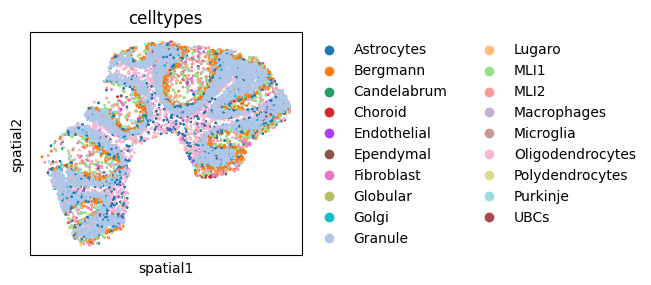

In [19]:
sq.pl.spatial_scatter(
        adata,
        shape = None,
        color = "celltypes",
        size=3
)

In [20]:
sq.gr.co_occurrence(adata, cluster_key = "celltypes")


/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:09<00:00,  9.30s/]


In [21]:
adata

AnnData object with n_obs × n_vars = 10098 × 50
    obs: 'x', 'y', 'celltypes'
    uns: 'celltypes_colors', 'celltypes_co_occurrence'
    obsm: 'spatial'

In [22]:
## get the co-occurance values
occ = adata.uns["celltypes_co_occurrence"]["occ"]
occ.shape

(19, 19, 49)

In [23]:
## get the intervals
intervals = adata.uns["celltypes_co_occurrence"]["interval"]
intervals.shape

(50,)

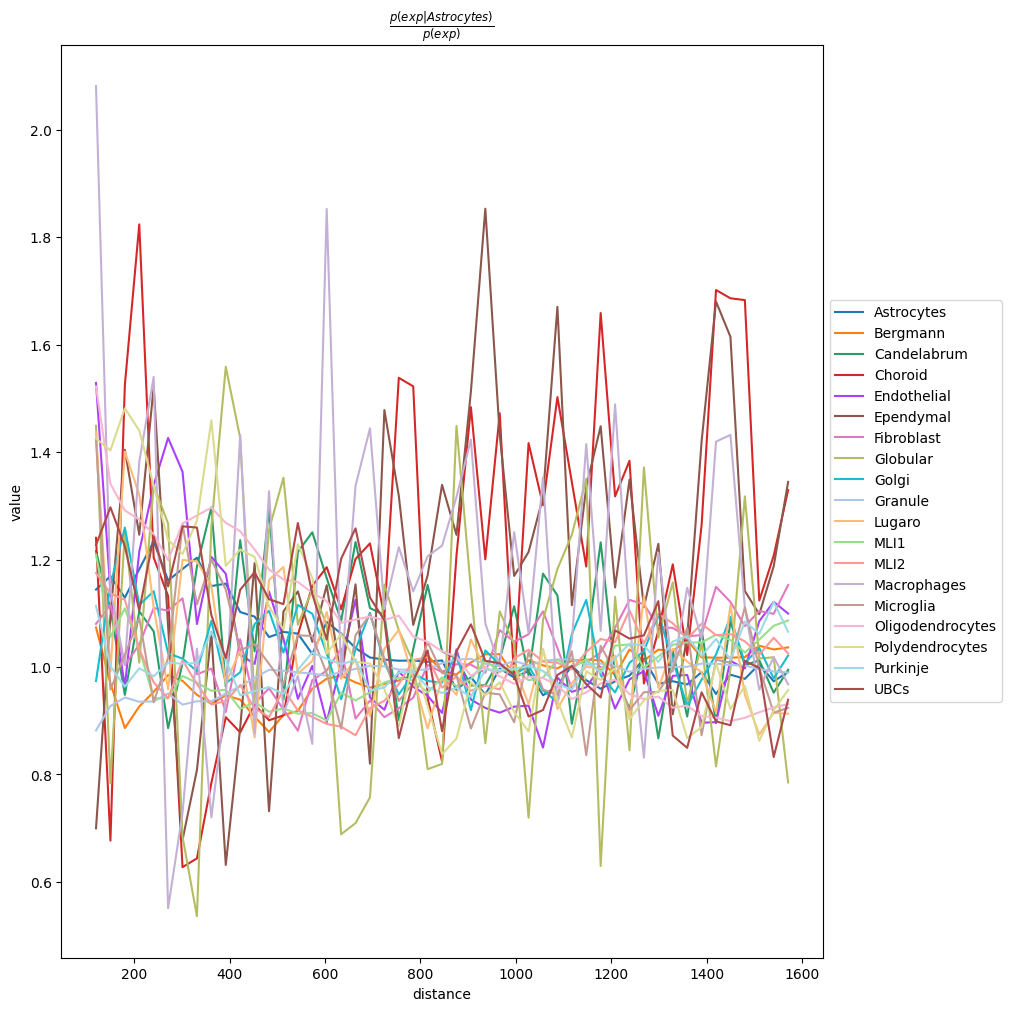

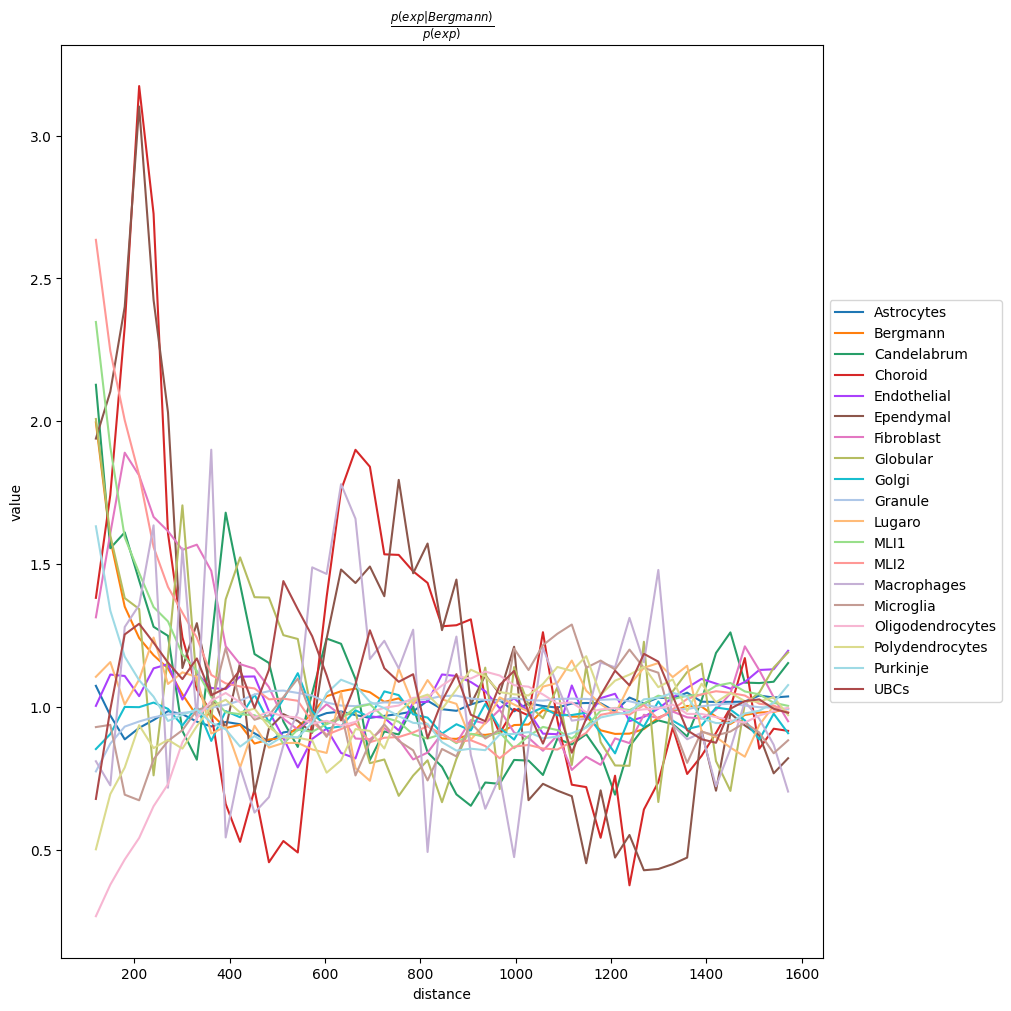

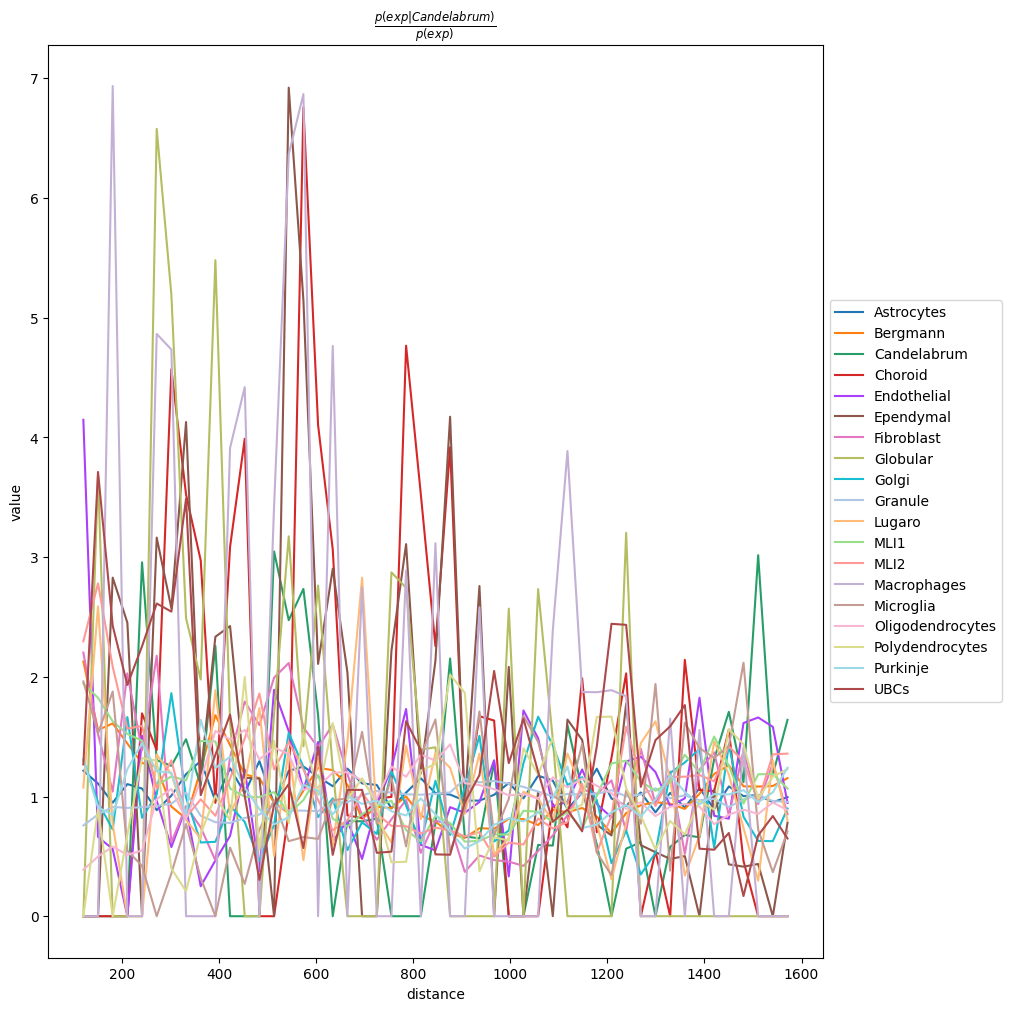

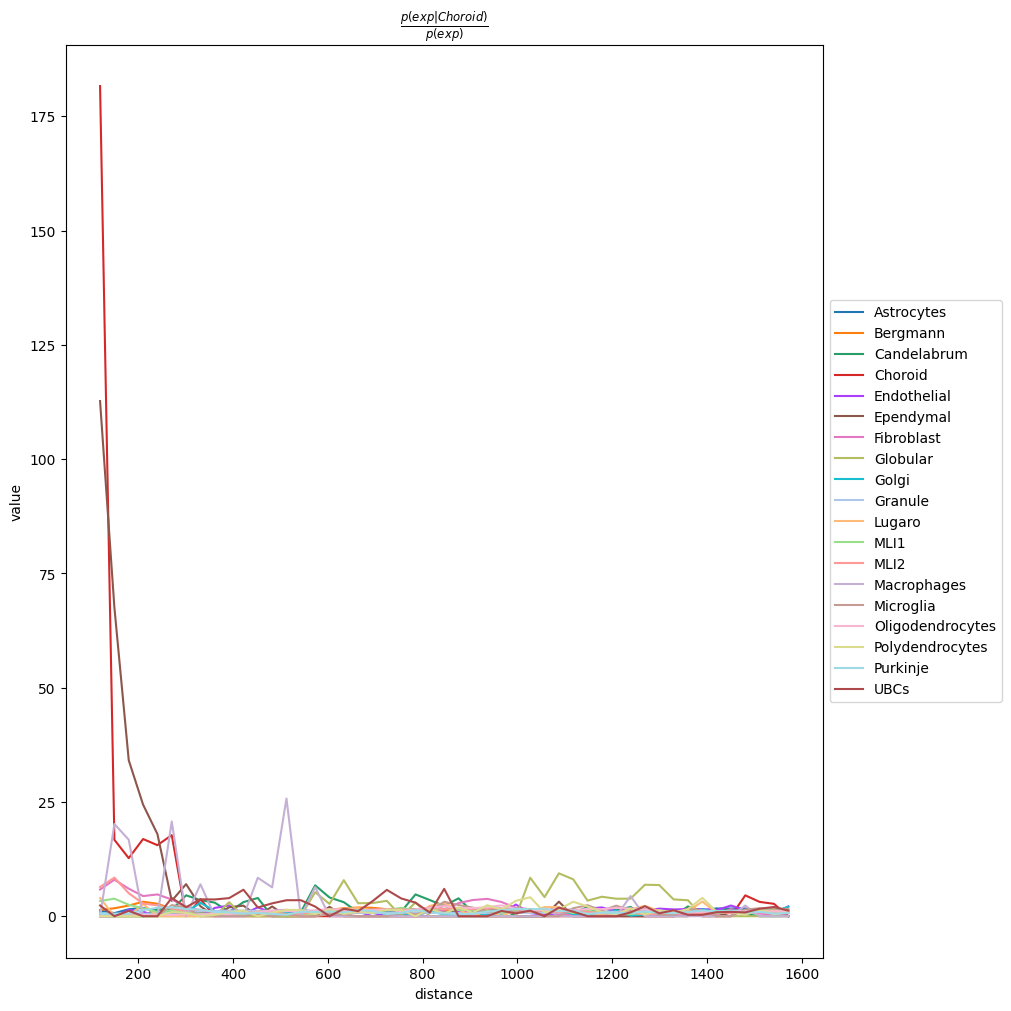

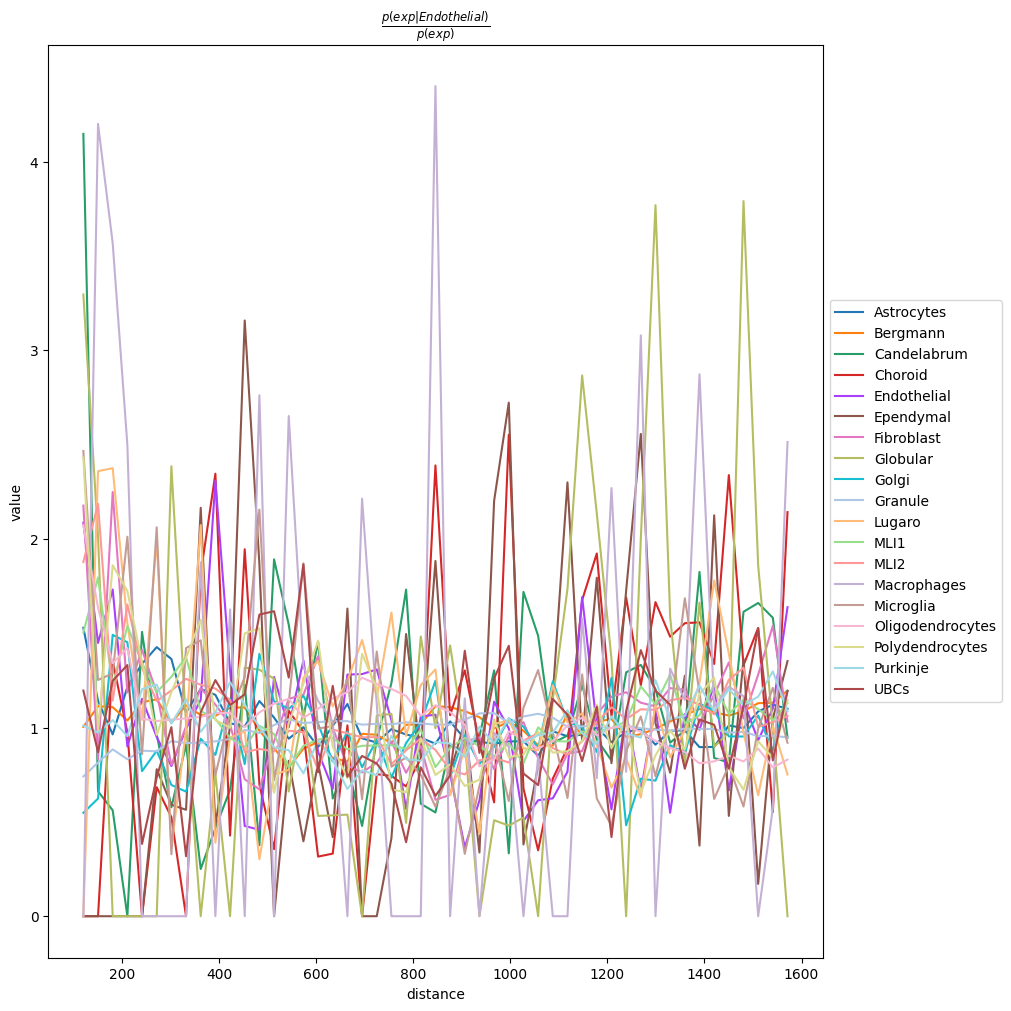

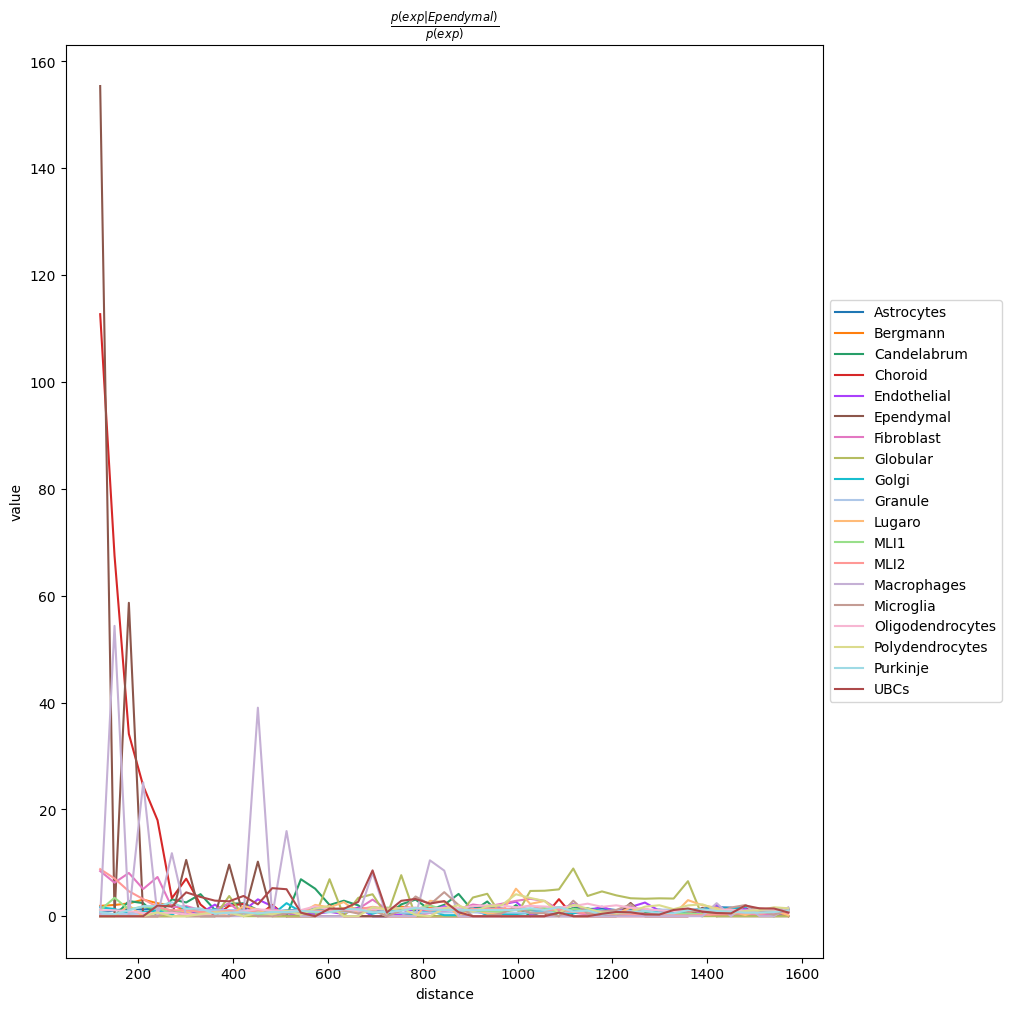

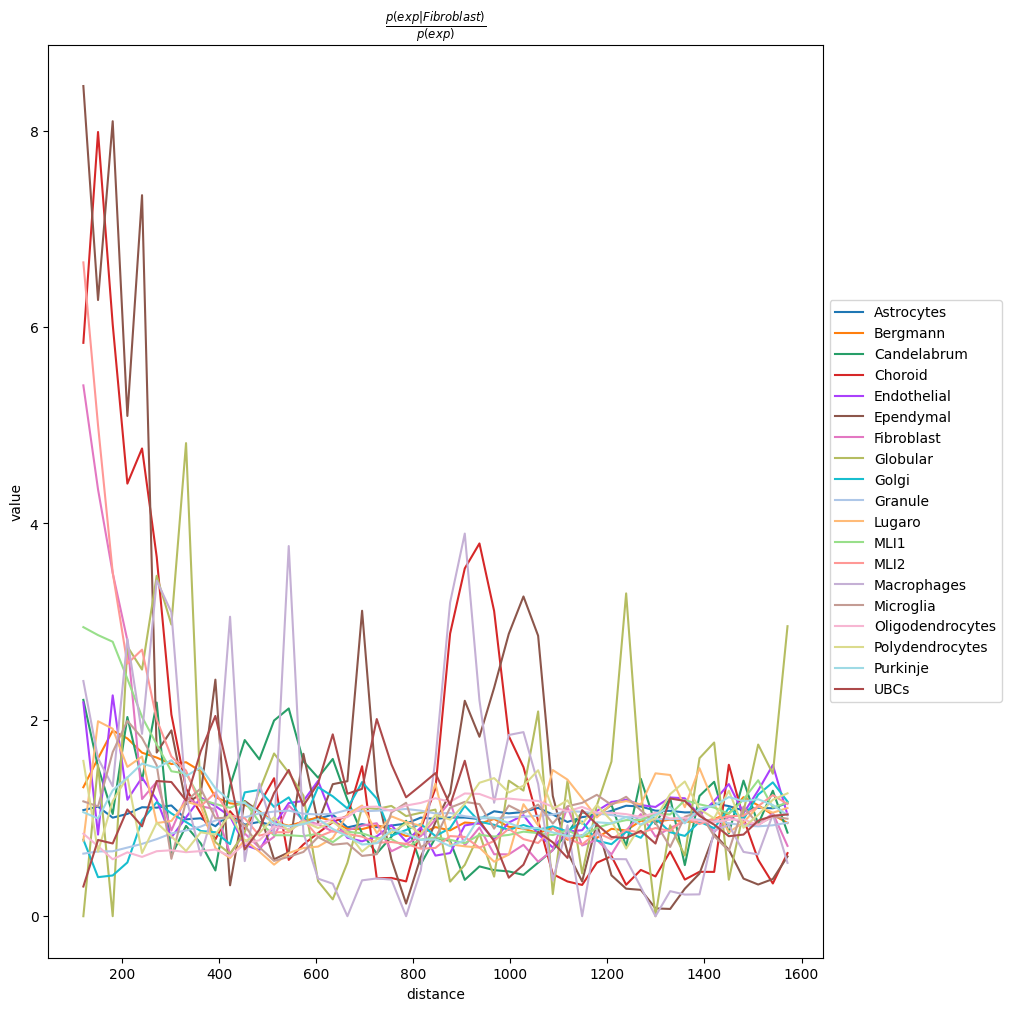

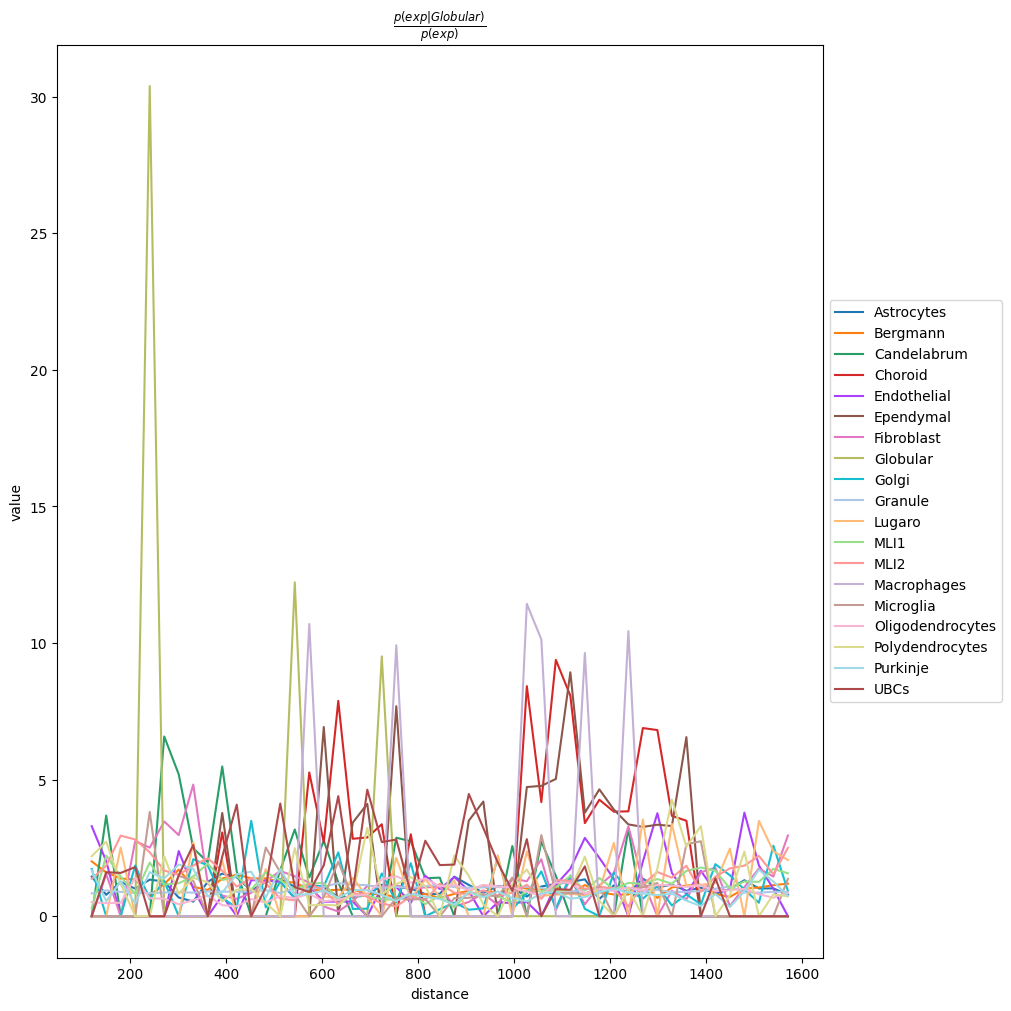

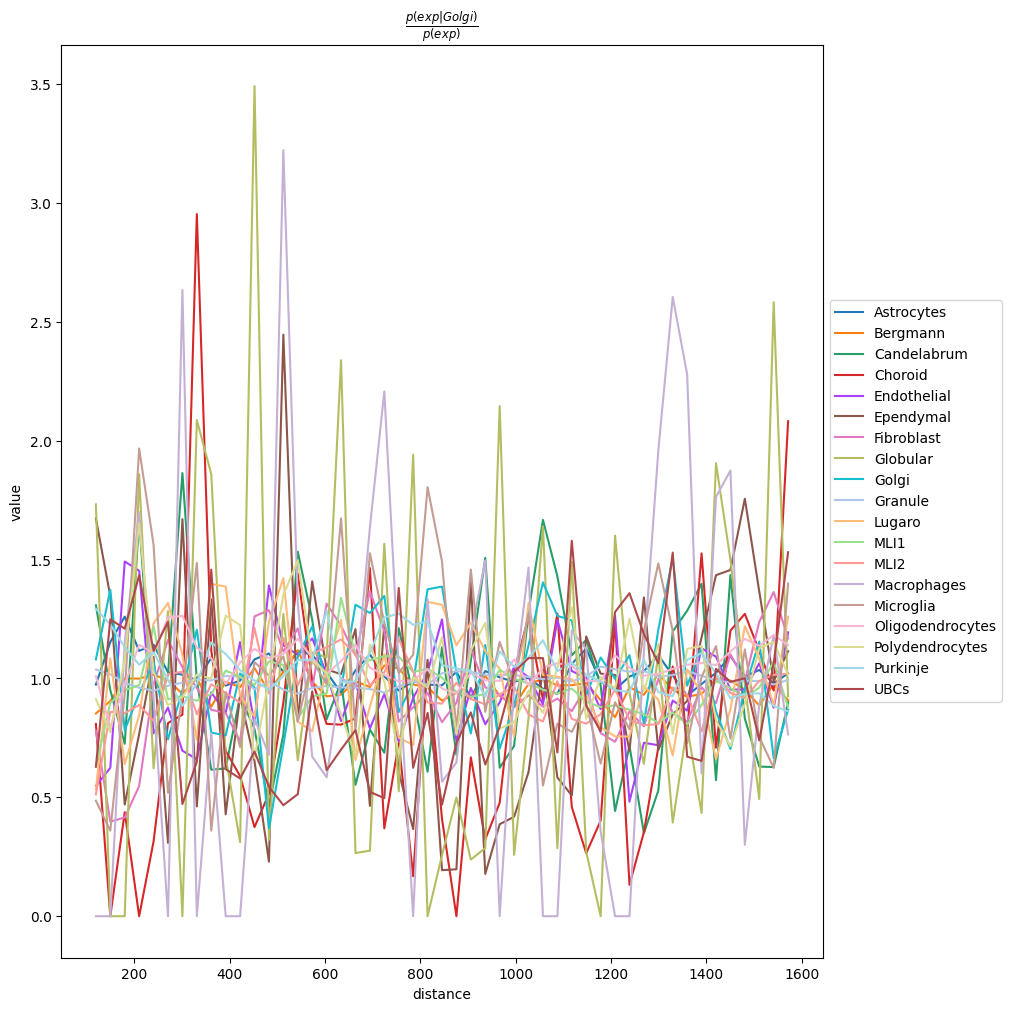

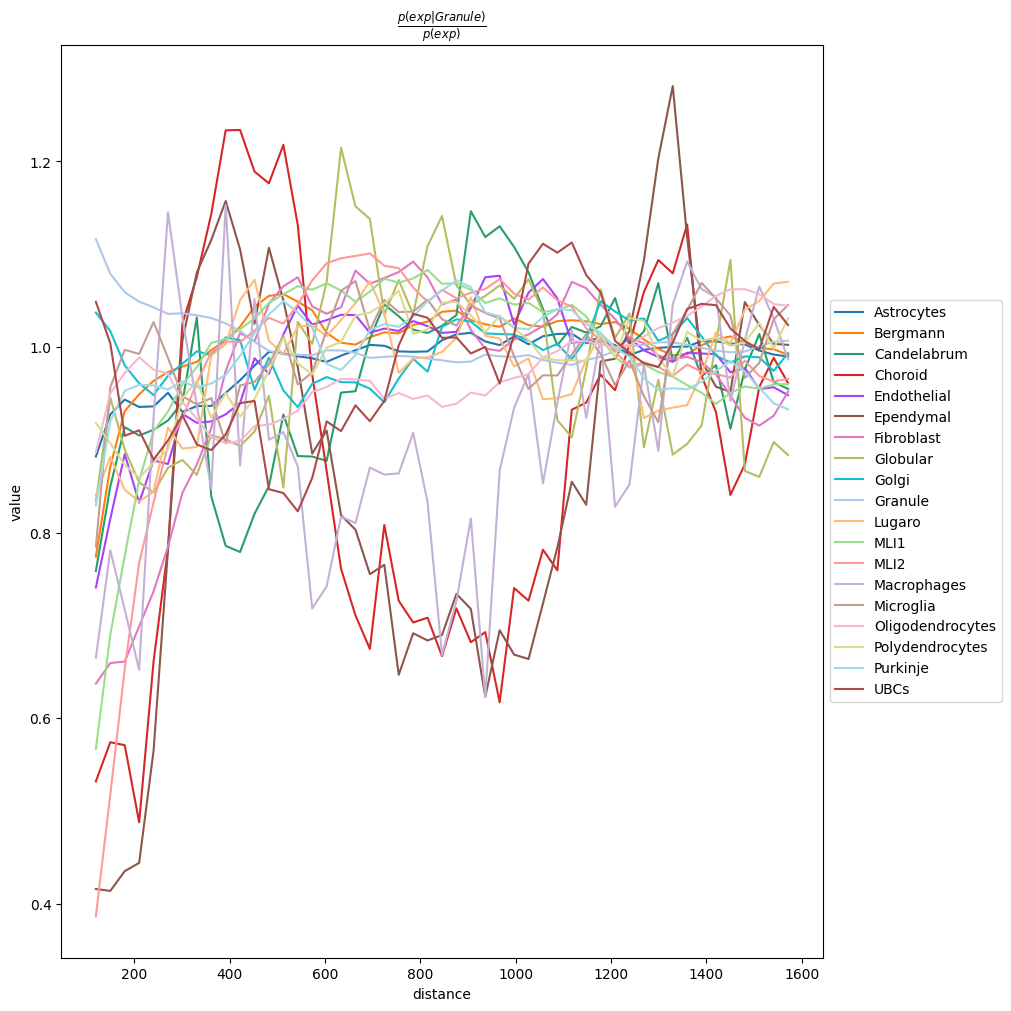

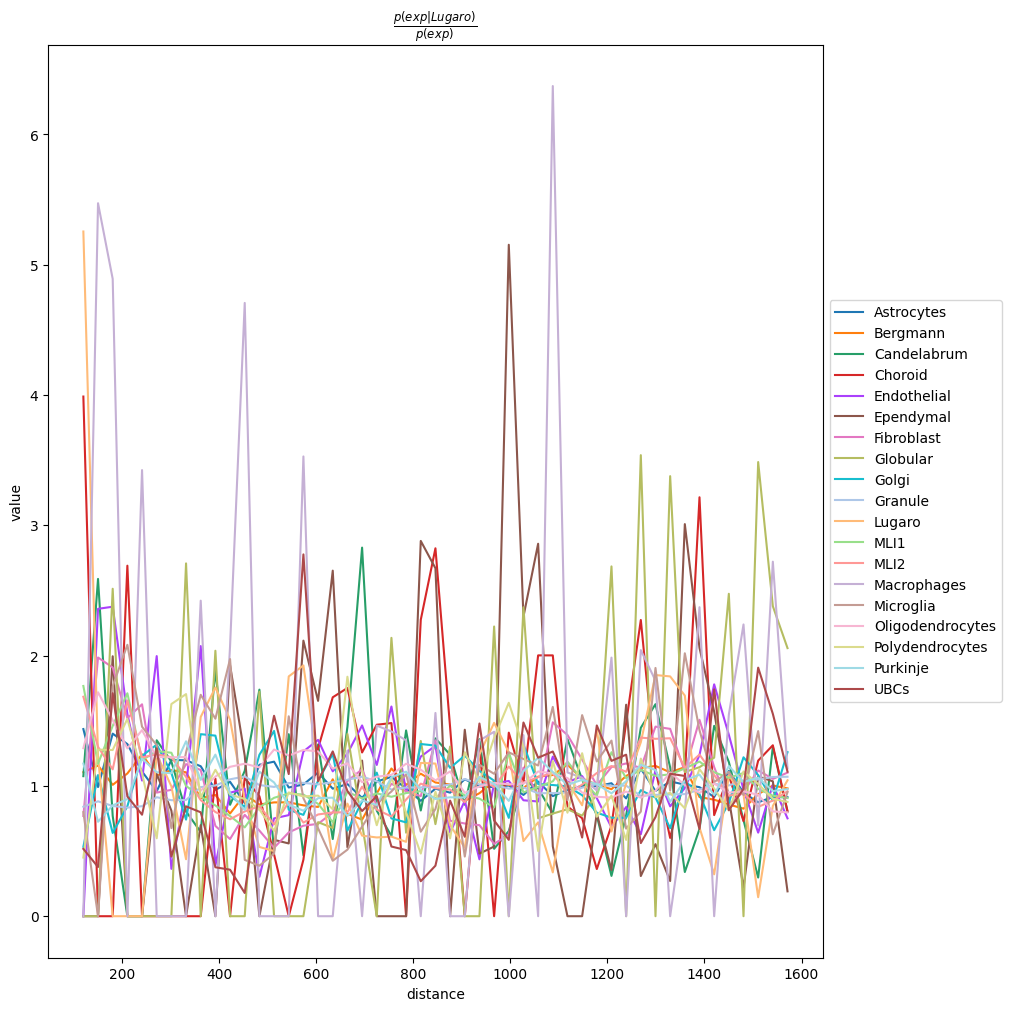

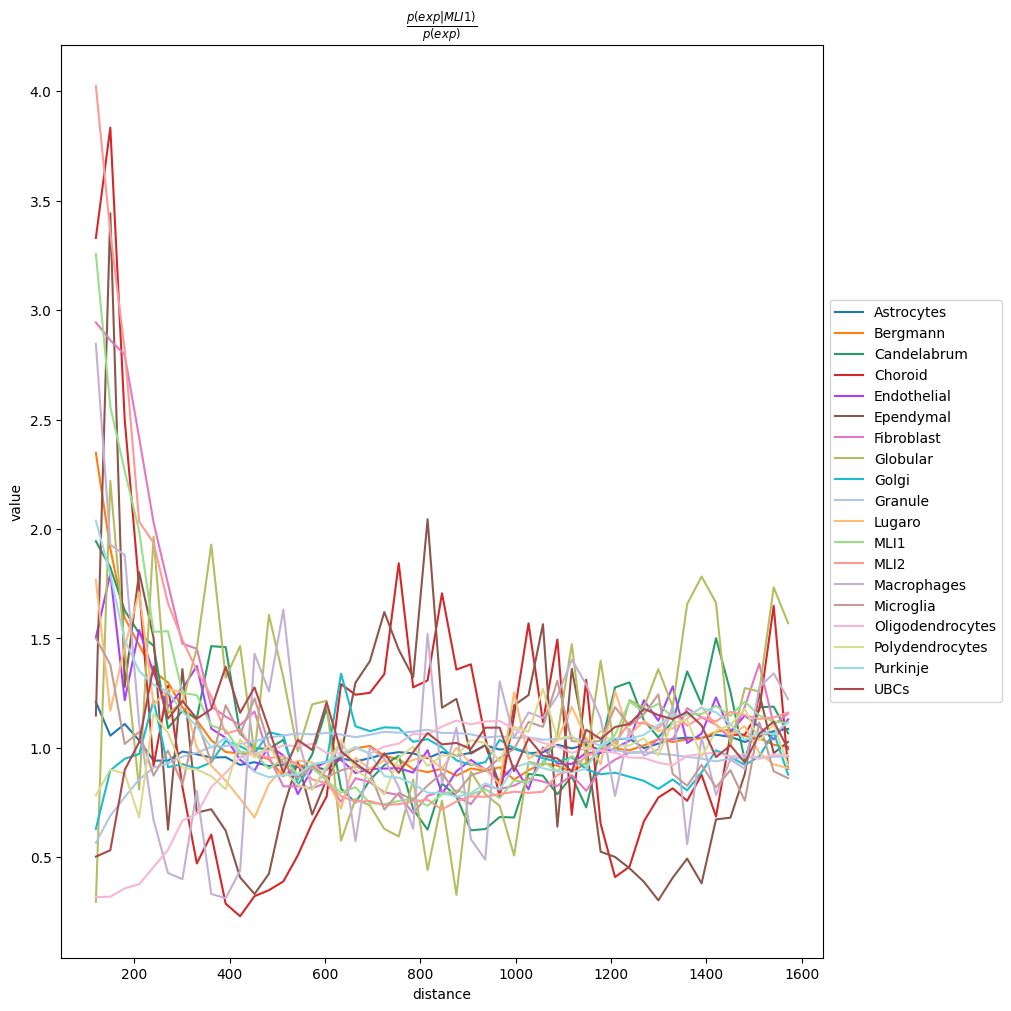

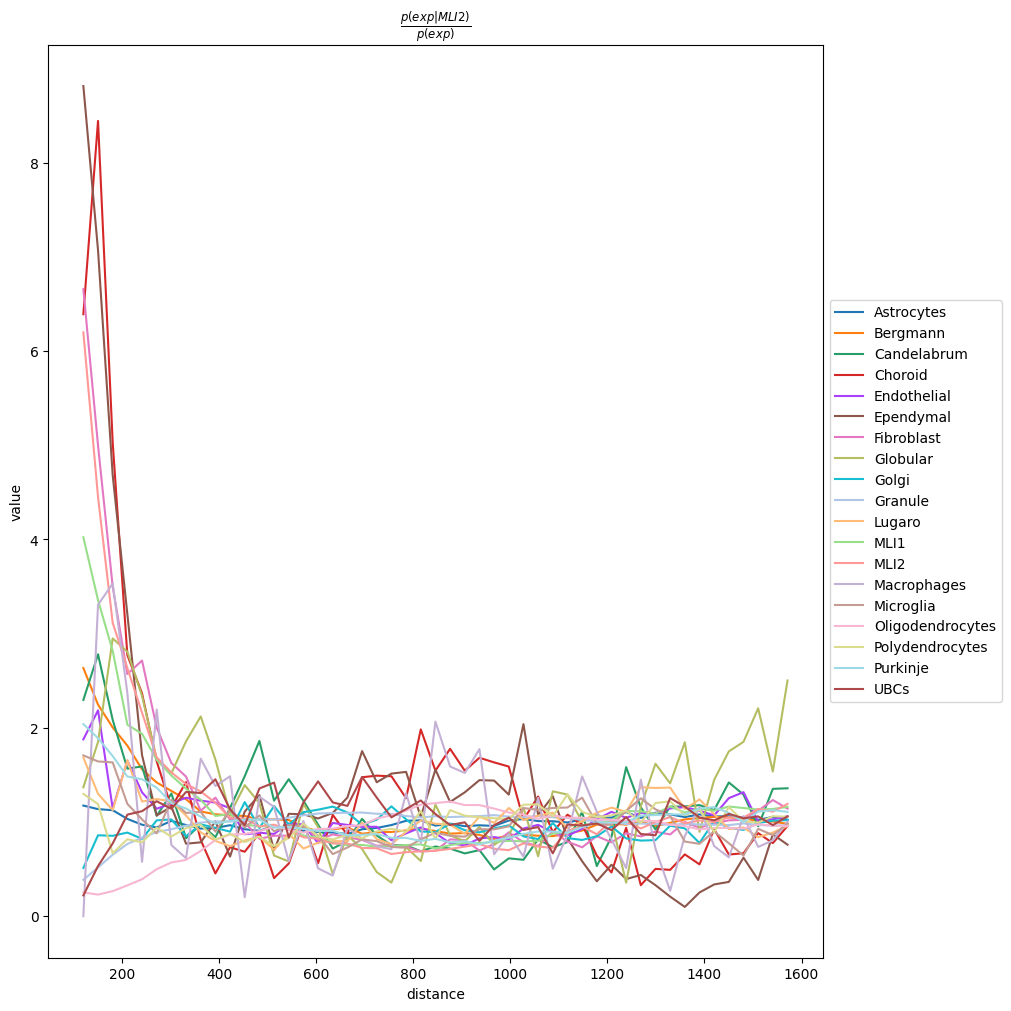

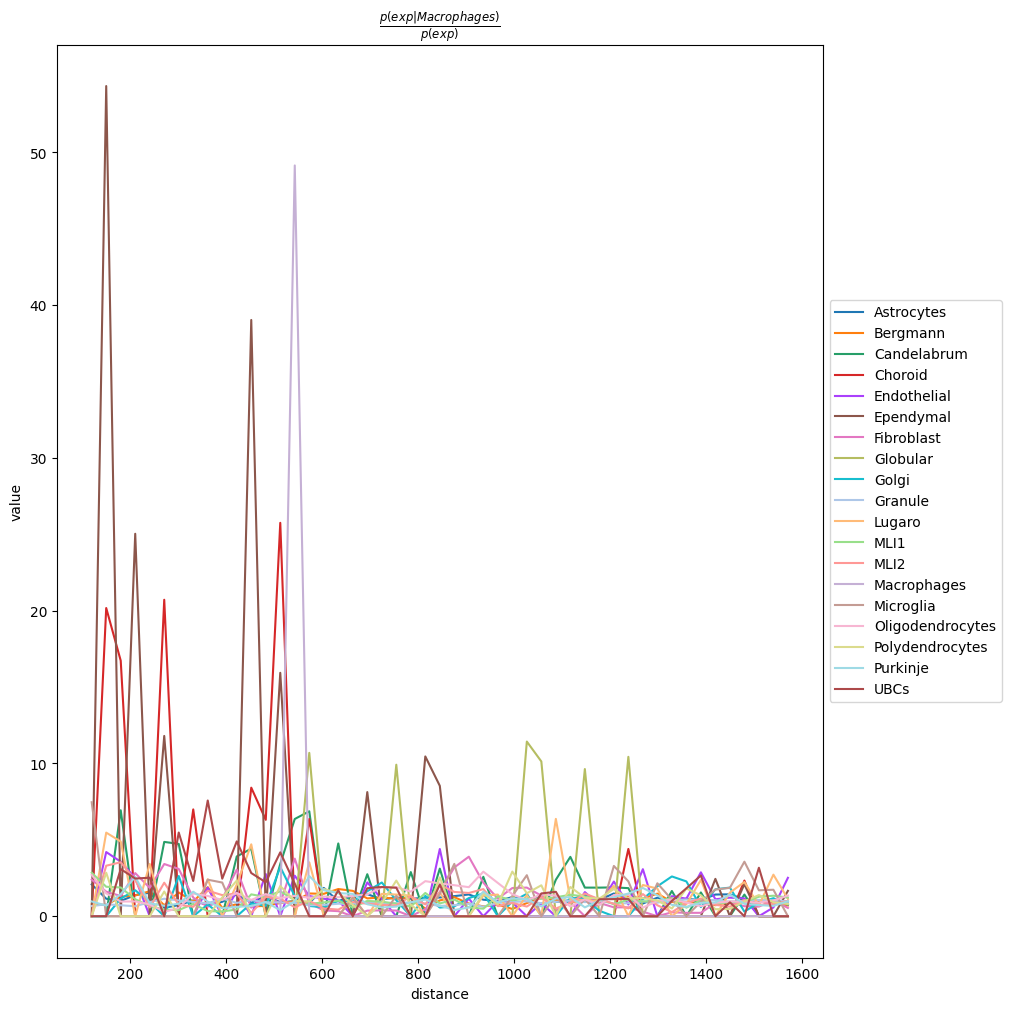

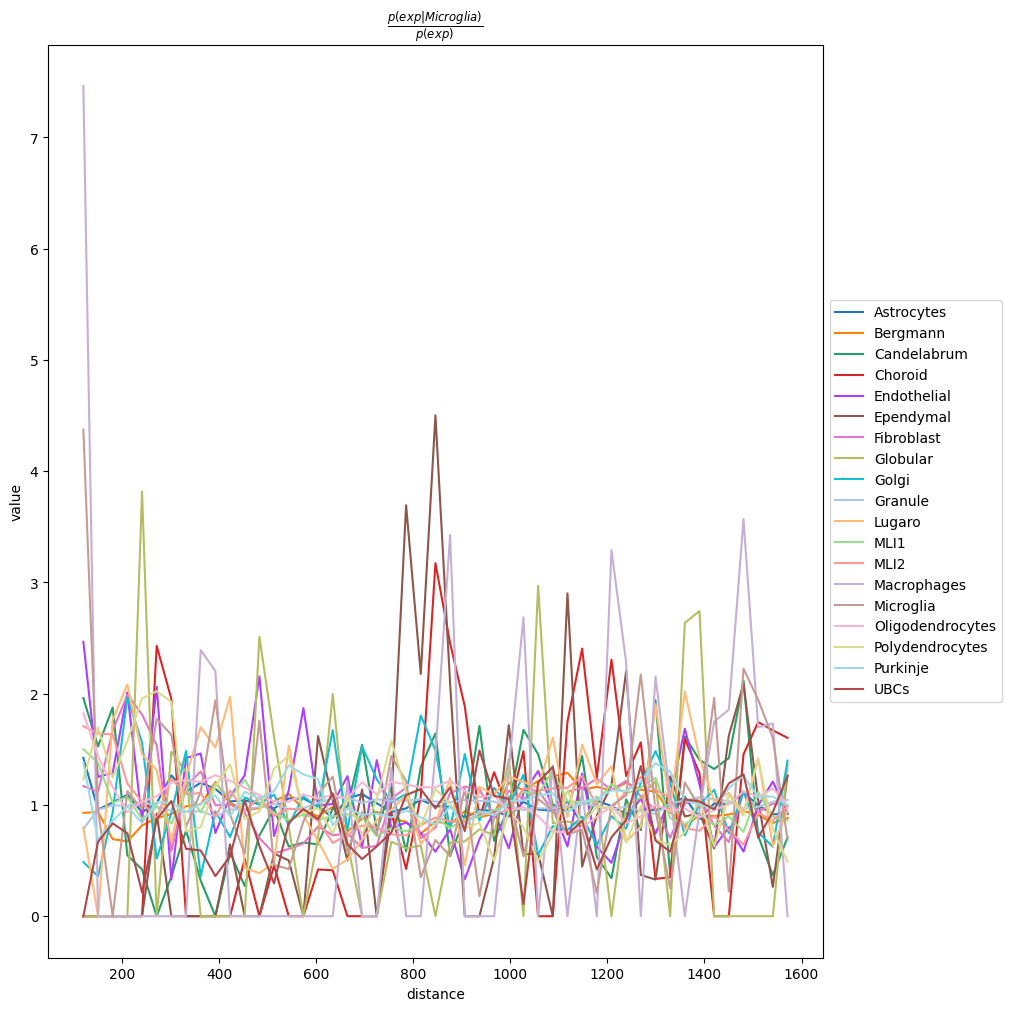

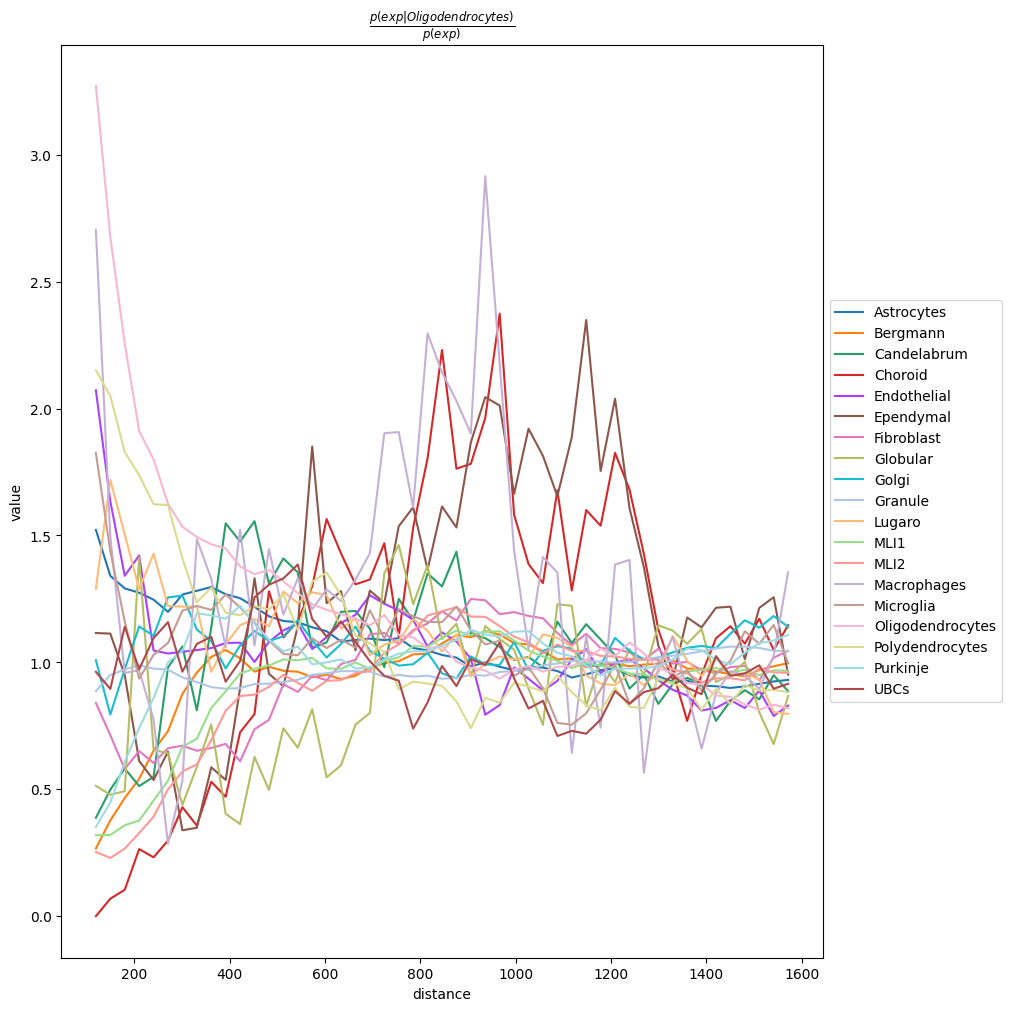

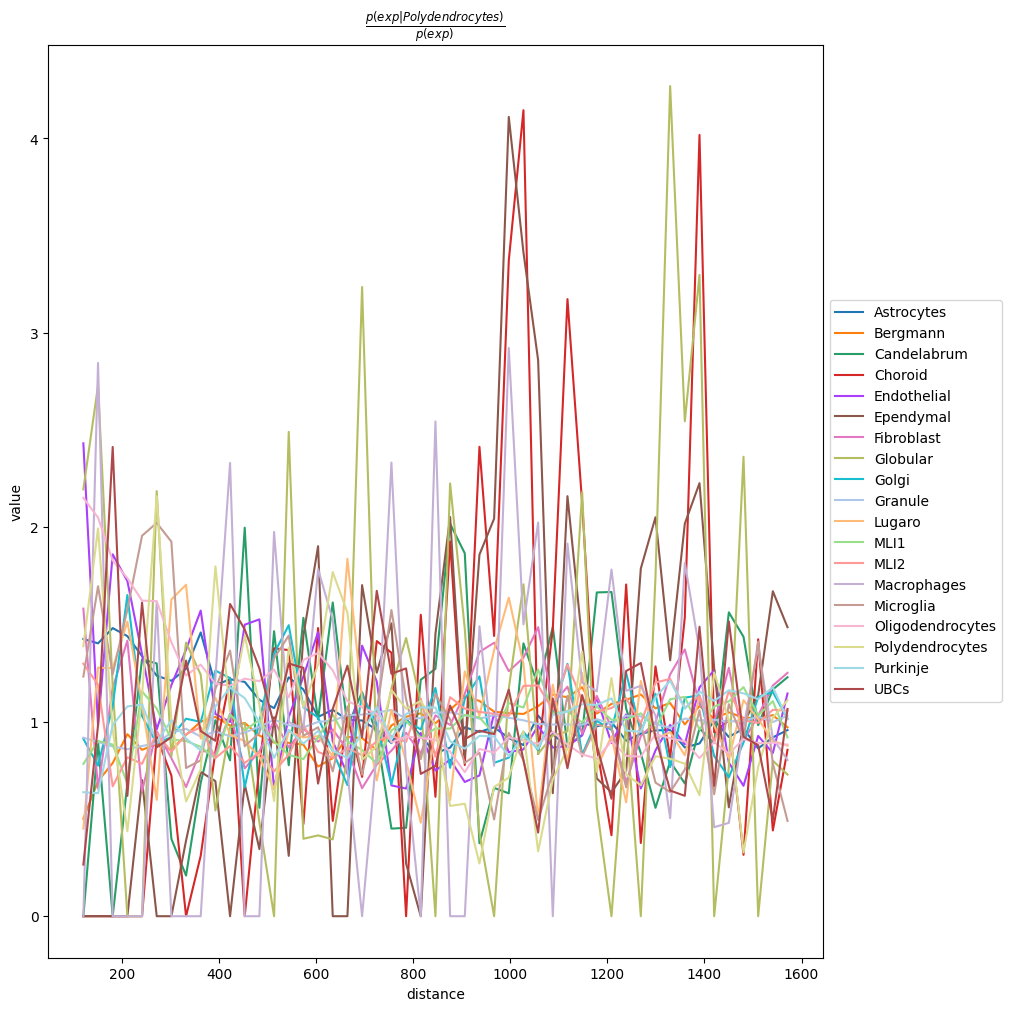

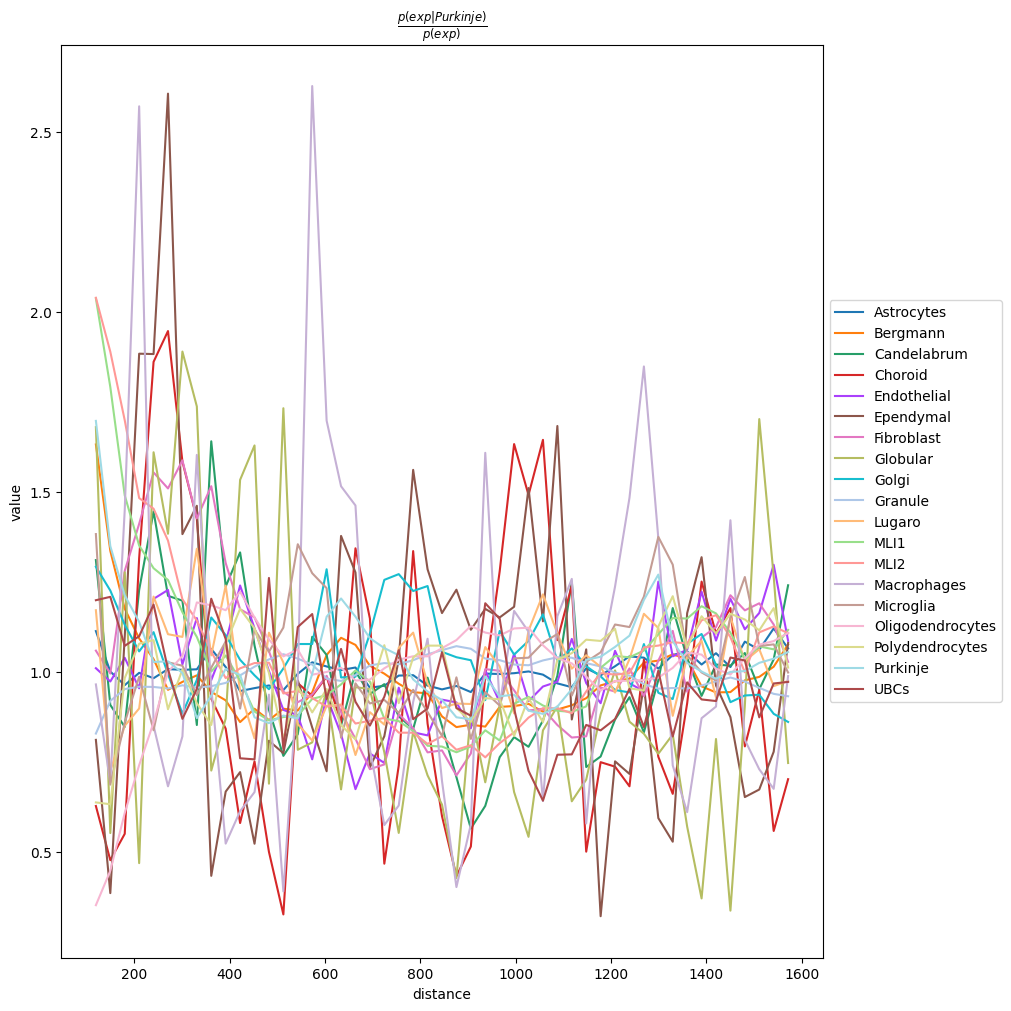

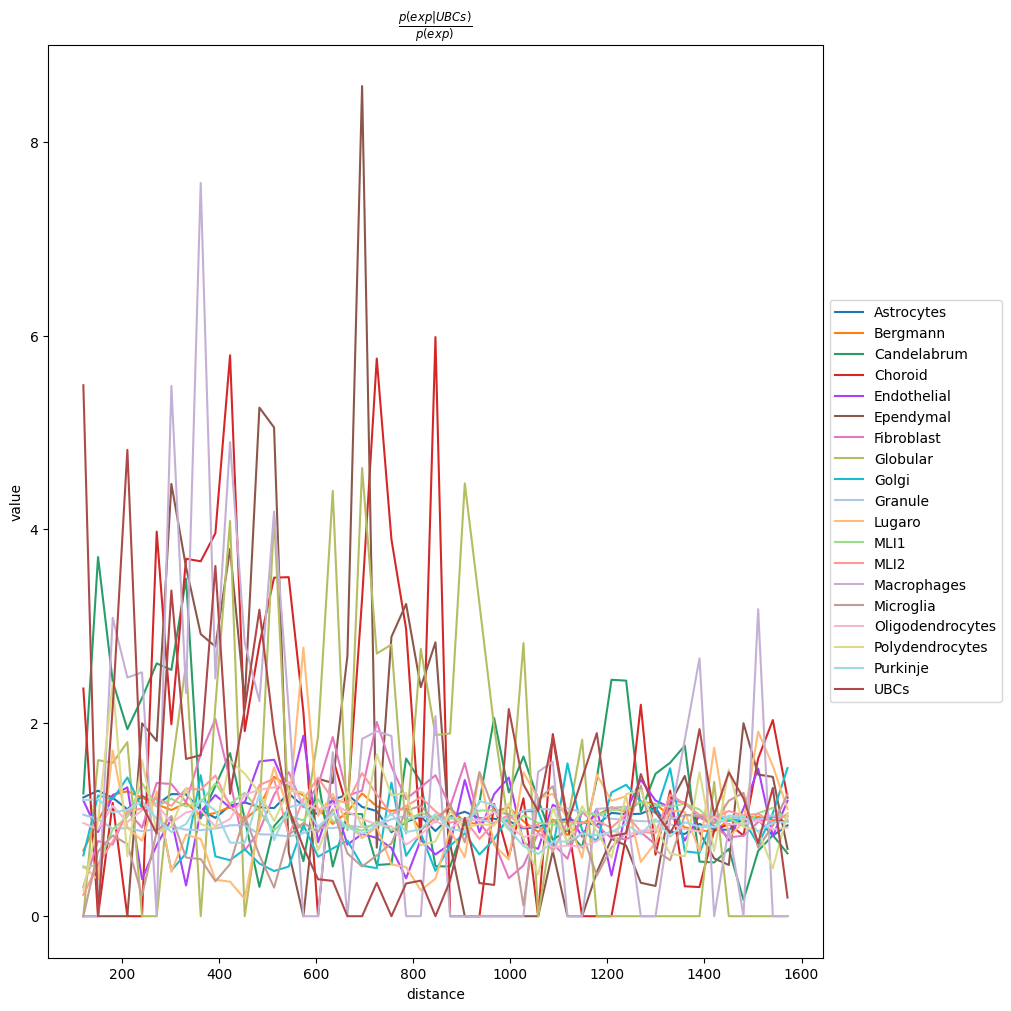

In [24]:
for ct in np.unique(adata.obs["celltypes"]):
    sq.pl.co_occurrence(adata, cluster_key="celltypes", clusters=ct,
                        save="simulation_co_occurance.{}.pdf".format(ct),
                        figsize=(10,10))

# Extract data

In [25]:
out = adata.uns["celltypes_co_occurrence"]["occ"]
interval = adata.uns["celltypes_co_occurrence"]["interval"][1:]
categories = adata.obs["celltypes"].cat.categories

## Create DF

In [26]:
cluster_key = "celltypes"

In [27]:
clusters = categories

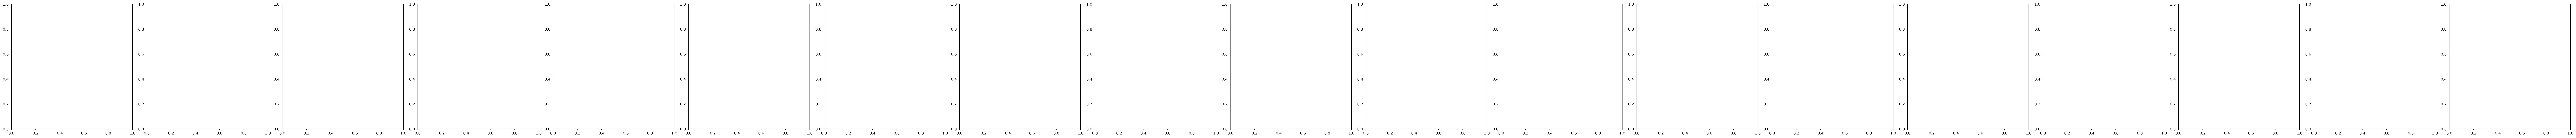

In [28]:
fig, axs = plt.subplots(
        1,
        len(clusters),
        figsize=(5 * len(clusters), 5),
        dpi=300,
        constrained_layout=True,
    )
axs = np.ravel(axs)

In [29]:
df_dict = {}

for g, ax in zip(clusters, axs):
        print(g)
        idx = np.where(categories == g)[0][0]
        df = pd.DataFrame(out[idx, :, :].T, columns=categories).melt(var_name=cluster_key, value_name="probability")
        df["distance"] = np.tile(interval, len(categories))
        df["reference"] = g
        df_dict[g] = df


Astrocytes
Bergmann
Candelabrum
Choroid
Endothelial
Ependymal
Fibroblast
Globular
Golgi
Granule
Lugaro
MLI1
MLI2
Macrophages
Microglia
Oligodendrocytes
Polydendrocytes
Purkinje
UBCs


In [43]:
result_df = pd.concat(df_dict.values(), axis=0, keys=df_dict.keys(), ignore_index=True)
result_df.head()

celltypes  probability    distance   reference
0  Astrocytes     1.144152  119.673508  Astrocytes
1  Astrocytes     1.169040  149.912079  Astrocytes
2  Astrocytes     1.129144  180.150635  Astrocytes
3  Astrocytes     1.182155  210.389206  Astrocytes
4  Astrocytes     1.233803  240.627777  Astrocytes

In [44]:
# > names(dat_50)
# [1] "perm"      "neighbor"  "Z"         "scale"     "reference" "id" 
# result_df.columns = ["neighbor", "Z", "scale", "reference"]
result_df.columns = ["neighbor", "probability", "distance", "reference"]

In [45]:
result_df["id"] = 0
result_df["perm"] = 1
result_df.head()

neighbor  probability    distance   reference  id  perm
0  Astrocytes     1.144152  119.673508  Astrocytes   0     1
1  Astrocytes     1.169040  149.912079  Astrocytes   0     1
2  Astrocytes     1.129144  180.150635  Astrocytes   0     1
3  Astrocytes     1.182155  210.389206  Astrocytes   0     1
4  Astrocytes     1.233803  240.627777  Astrocytes   0     1

In [46]:
result_df.to_csv('dat_slide_squidpy.csv')